# What Really Predicts Rental Prices in Los Angeles?
### Allie Padgett, Michael Rosen, Nicole Matteson, Seth Reichert
### Urban Data Science (2022)

**Table of Contents:**
1. [Introduction](#intro)
2. [Acquiring Data](#acquiring)
3. [Cleaning, Wrangling, and Joining Data](#cleaning)
4. [Machine Learning](#learning)
5. [Conclusions](#conclusion)


<a id='intro'></a>
## 1. Introduction
Much ink has been spilled trying to untangle the relationship between demographics, rental prices, and new construction in a city – especially in a city as expensive and racially stratified as Los Angeles. These analyses often focus on trying to establish causal relationships or examining change over time, often with a goal of developing policy interventions that could slow the rise of rent prices. 

We sought to put our own twist on this analysis by bringing in the most up to date rental information it is possible to obtain – live rental listings from Craigslist. Additionally, rather than establishing causal relationships, we were primarily interested in the predictive power enabled by machine learning techniques: can demographic information and building permit data predict rent prices? This situates our research purely in the present, rather than seeking to understand the past, which is both a limitation and an asset. 

Our approach posed several methodological challenges, most notably difficulty in scraping the Craigslist data (discussed in more detail below). The other significant challenge was in cleaning and joining our data – as we have come to expect with "big data," there were many instances where data did not align perfectly or required quite a bit of wrangling. However, once we were able to build a dataframe with listings, census variables, and permit data, the machine learning components were more straightforward. 


In the end, we found a weak relationship at best between the number of building permits issued and the rental prices in a given census tract. In fact, the most important feature for predicting rent prices was the racial makeup of the census tract – specifically the percentage of Black or Asian residents. While this is a depressing outcome in many ways, it also reflects the realities of our racially and economically segregated city (and the ways in which those two are heavily interrelated). 


<a id='acquiring'></a>
## 2. Acquiring Data

For this project we used data from: 
- 2019 ACS 5 year variables 
- Los Angeles Building Permits
- Craigslist rental listings

The data acquisition stage took a particularly long time due to challenges with web scraping craigslist listings and circumnavigating anti-scraping measures. 

### Census Data
We aquired census data through the Cenpy package and pulled the following variables:
- Median Household Income
- Population
    - Total Population
    - White 
    - Black or African American
    - American Indian or Alaskan Native
    - Asian 
    - Hawaiian or Pacific Islander
    - Other
- Education
    - Total
    - Bachelor Degree
    - Masters Degree
    - Professional Degree
    - Doctoral Degree

We then calculated percentages for the various demographic statistics to serve as our primary variables. 

The next step was to clip census tracks to the City of LA boundry. Since everything else we used was based on the city boundaries of Los Angeles, we chose to clip based on this boundry. We did not adjust our variables to reflect any change in geometry (tract boundaries do not line up with city boundaries), in part because we assumed that are few census tracts where the distribution within the census tract is varied enough to make a significant impact in our estimates. While this is a possible limitation of our analysis, we suspect the impact is relatively minor given the small geographic units in question (tracts). Below you can find an example of of a clipped map showing the percentage of non hispanic white residents.

Further details on how this data was pulled and cleaned, as well as some first exploratory maps can be found in our repository's [Census data](Census%20data.ipynb) notebook.

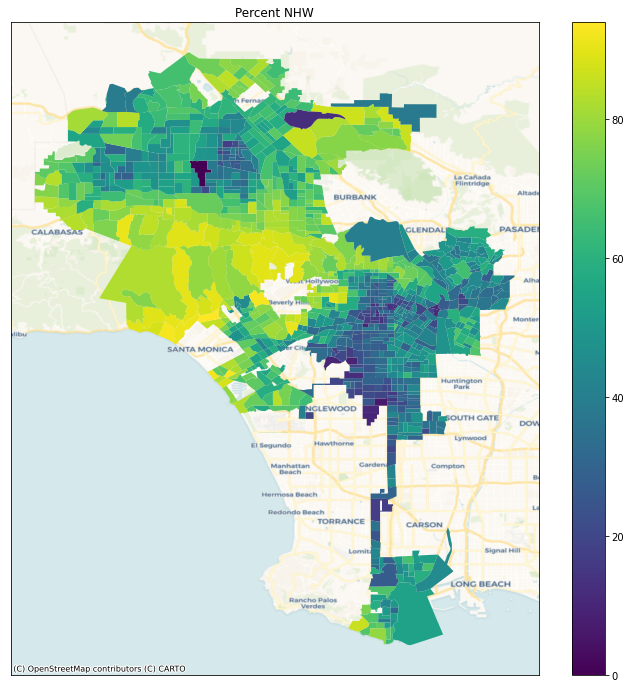

In [5]:
# importing libraries
import requests 
from requests import get
import pandas as pd
import geopandas as gpd
import json
import cenpy
from cenpy import products
import matplotlib.pyplot as plt
import contextily as ctx

# for the purposes of this notebook, pulling in exported data from previous files
census_gdf = gpd.read_file('Data/CensusPlusPermits.geojson', crs='EPSG:4326')
fig, ax = plt.subplots(figsize=(12, 12))
census_gdf.plot('PctNHW', ax = ax, legend=True)

# remove the tick labels
ax.set_xticks([])
ax.set_yticks([])

# set title, add basemap
ax.set_title('Percent NHW')
ctx.add_basemap(ax, crs=census_gdf.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

### Permit Data
We pulled building permit data from the city of L.A.'s building permit dataset and specifically pulled permits for new construction from 2013 to May 2022 to limit the data set, after a brief exploration with the basic socrata API we switched to using the Sodapy package to build a more direct query. Details on this process can be found in the [Permit Data Acquisition](Permit%20Data%20Acquisition.ipynb) Notebook.

Below you will also find a map of permit hotspots in L.A.

In [ ]:
from sodapy import Socrata
import numpy as np
from scipy import ndimage
from time import time

In [6]:
# reading in file
permit_gdf = gpd.read_file('Data/permit_gdf.geojson', crs='EPSG:4326')

# Heatmap adapted from: https://nbviewer.org/gist/perrygeo/c426355e40037c452434

def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet', alpha=.3, title='title'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]
        # functions to return list of x and y coordinates
    
    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins) # places x and y points into bins 
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    fig, ax = plt.subplots(figsize=(12,12))
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent, alpha=alpha, zorder=15) 
    # controls coloring and details of map including drawing order (necessary for avoiding conflicts with the basemap)
    ctx.add_basemap(ax, crs=d.crs.to_string())
    ax.set_title(title, fontsize=18)
    plt.colorbar()
    plt.gca().invert_yaxis()
    
    plt.show()

/var/folders/dh/8tmq12d56mx289p14g_tpzmw0000gn/T/ipykernel_12234/2874645403.py:18: RuntimeWarning: divide by zero encountered in log
  logheatmap = np.log(heatmap)
/var/folders/dh/8tmq12d56mx289p14g_tpzmw0000gn/T/ipykernel_12234/2874645403.py:20: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')


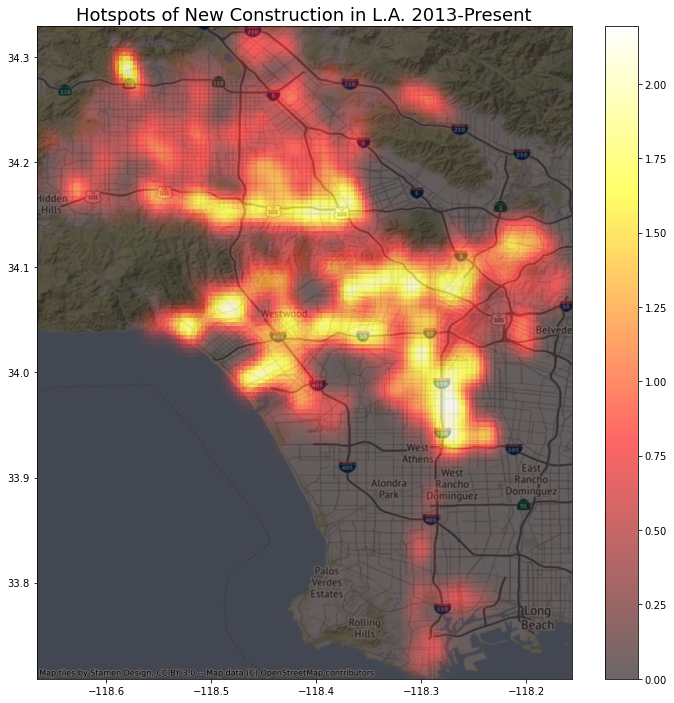

In [7]:
heatmap(permit_gdf, bins=(150,150), smoothing=2, cmap='hot', alpha=.6, title='Hotspots of New Construction in L.A. 2013-Present')

### Craigslist Scraping

Scraping the listings from Craigslist was by far the most challenging and time consuming portion of this project. It was particularly challenging at first to loop over the pages of Craigslist listings without having our IP addresses temporarily blocked. Once we developed a system to pull pages of Craigslist data we also needed to pull point data for each listing, which was time consuming. Craigslist organizes listings based upon five areas of L.A.: Long Beach, Central L.A., San Fernando Valley, San Gabriel Valley, and the West Side (plus Antelope Valley, which was outside our scope). We divided the areas between ourselves to save time, and ran the process to pull listings and geometry before joining them together.

The listings and geometry that we pulled were all obtained between May 22nd and 25th.

#### Scraping Listings

To scrape the Craigslist listings, we need to get the number of listings for the area of L.A. and loop over each page of listings. A complete notebook with exploratory pulls and checks for unique listings can be found in the [la_apt_scrape](la_apt_scrape.ipynb) notebook.

In [8]:
# pull a first page of listings to later find the number of listings available 
response = get('https://losangeles.craigslist.org/search/lgb/apa') 

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

In [9]:
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other and randomizing the time between calls
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://losangeles.craigslist.org/search/lgb/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
#                    + "&hasPic=1"
#                    + "&availabilityMode=0"
                  )

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = page_html.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, and turns it into an int
            post_price = post.a.text.strip().replace("$", "")
            post_prices.append(post_price)
            
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")


#loading posts into a data frame
lgb_apts = pd.DataFrame({'posted': post_timing,
                       'neighborhood': post_hoods,
                       'post title': post_title_texts,
                       'number bedrooms': bedroom_counts,
                        'sqft': sqfts,
                        'URL': post_links,
                       'price': post_prices})
lgb_apts.head()

/var/folders/dh/8tmq12d56mx289p14g_tpzmw0000gn/T/ipykernel_12234/3574052943.py:6: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!


Scrape complete!


,posted,neighborhood,post title,number bedrooms,sqft,URL,price
0,2022-06-01 21:05,(long beach / 562),1 Bedroom 1 Bathroom Move In Ready,1,700.0,https://losangeles.craigslist.org/lgb/apa/d/no...,"1,891"
1,2022-06-01 20:22,(long beach / 562),"1 Bed, Zen garden and sundeck, Situated in Lon...",1,656.0,https://losangeles.craigslist.org/lgb/apa/d/lo...,"2,572"
2,2022-06-01 19:50,"(8121 Broadway Blvd, Los Angeles, CA)","Offer Virtual Tours, Updated fixtures, Heating...",2,811.0,https://losangeles.craigslist.org/lgb/apa/d/wh...,"2,420"
3,2022-06-01 19:27,(long beach / 562),"1/BD, Courtyard views, Located in Long Beach",1,656.0,https://losangeles.craigslist.org/lgb/apa/d/lo...,"2,572"
4,2022-06-01 18:53,(Downey),Downey 1 Bedroom 1 Bath W/ Air Conditioning + ...,1,610.0,https://losangeles.craigslist.org/lgb/apa/d/do...,"1,750"


#### Geometry Scraping

We tested the methodology for retrieving latitude and longitude coordinates seperately to avoid making too many calls to Craigslist. Once we found a successful method we had to build a similar randomized sleep timer into our function avoid being blocked by Craigslist. The resulting function took about two hours to run for every 3000 listings, which is why we split it up between individual group members to run for individual sections of L.A.

We have not run the function in this notebook and instead are only providing examples of code due to the length of time it takes to run. 

The full method can be found in the [Lat_Long](Lat_Long.ipynb) notebook.

In [ ]:
def get_latlong(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    try:
        link = soup.find_all('div', class_='viewposting') #where the geometry is consistently located in the listings
        
        #lat and long are contained within a dictionary within a list, these extract the data.
        lat = link[0]['data-latitude'] 
        long = link[0]['data-longitude']
        
        #this randomizes the time between calls to craigslist and slow down the scraper and avoid being blocked.
        time.sleep(random.uniform(.5,3))  
    
        return [lat, long]
    except:
        return [None, None] #return none if error from searching for lat/long or if the page is no longer available

We then applied this function along the URL to return a column named `latlon` that contains a list of `[y,x]` and created x and y columns with the values from this list:

`df['y'] = df['latlon'].apply(lambda x: x[0])` 

`df['x'] = df['latlon'].apply(lambda x: x[1])`

<a id='cleaning'></a>
## 3. Cleaning, Wrangling, and Joining Data

### Joining Our Datasets into the Grand Dataset

After finally scraping current listing data, we had listings datasets for each of the five Los Angeles neighborhoods: San Fernando Valley, Westside, Central Los Angeles, Long Beach, and San Gabriel Valley. After some cleaning (for instance, the dataset for San Fernando Valley had an error where the "x" coordinates dropped a negative sign, solved by multiplying that column by -1) we aggregated the listings into one data frame. 

Separately, we also had a dataset of LA's new construction permit data and a geodataframe with demographic variables in each census tract. 

In order to get to a place where machine learning was possible, all of these dataframes needed to be combined. Additionally, we wanted to calculate some aggregate statistics per tract: most importantly, counts of permits and rental listings along with mean and median rental prices. 

The first step was to do a spatial join of permit data and our census tract geodataframe, in order to assign each permit a tract. From here, we used groupby to get a count per tract, and join that back to the census geodataframe.

In [ ]:
# here is a sample of that process for the permit data
# full code can be found in the Permits Groupby and Mean Median Rent Per Tract- May 28 notebooks

# pulling in clipped LA shapefile with census data
lacensus=gpd.read_file('/Data/lacounty_clipped.geojson')

# setting projections and spatial joining census data to permit data to get tracts for each permit
# lacensus = clipped shapefile w tracts & census variables
# permitdata = permit info
# permitcensus = permit info w/ tracts assigned
permitdata=permitdata.set_crs('EPSG:4326')
lacensus=lacensus.to_crs('EPSG:4326')
permitcensus = gpd.sjoin(permitdata, lacensus, how="left", predicate='intersects')
permitcensus.head()

permit_counts=permitcensus.groupby(['GEOID']).count()['assessor_parcel']

# join permit counts back to census shapefile
permitcensus.set_index('GEOID', inplace=True)

permit_counts.name = 'permit_count'
censuspermitcounts = lacensus.join(permit_counts, on = 'GEOID', how='left')

Separately, we calculated the various rental listing statistics (count of listings, average and median rental price, average and median square footage, and average and median number of rooms for each census tract). We followed a similar process as with the permit data (see [Mean Median Rent Per Tract](Mean%Median%Rent%Per%Tract-%May%28.ipynb) notebook for full code). The first step was to to turn the columns from our Craigslist scrape into numeric variables, at which point we were able to use the groupby and count functions as well as mean and median functions to give us the variables we were looking for. We created a dataframe of the listing count and average rent and kept adding series to the dataset. We only kept the census tracts that had more than 5 listings so that our averages wouldn’t be too skewed, though this had the effect of significantly limiting our tract selection.

Once these statistics had been calculated, we added them to the census + permit count dataframe, creating what we called our Grand Dataframe -- a list of tracts with demographic information (census variables), permit counts, and rental listing statistics. This served the added purpose of limiting our listings to those that were in tracts within the city of LA.

<a id='learning'></a>
## 4. Machine Learning

After all of this messy cleaning, scraping, and joining, it was finally time for the fun part: building a machine learning model that attempted to predict rental prices for our Craigslist listings. We have included more of the code for this section in this notebook, as it is the "final product."

We started by importing the grand dataframe, dropping all of the null values, and forming a rent price per square foot variable to include in our analysis.

In [23]:
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [13]:
df=gpd.read_file('Data/Grand_Gdf.geojson')

In [14]:
df=df.dropna()

In [15]:
df['$persqft']=df['avg price']/df['avg sqft']

To get an initial sense of the spatial nature of our data, we mapped census tracts by their price per square foot rent prices and the number of permits in each census tract.

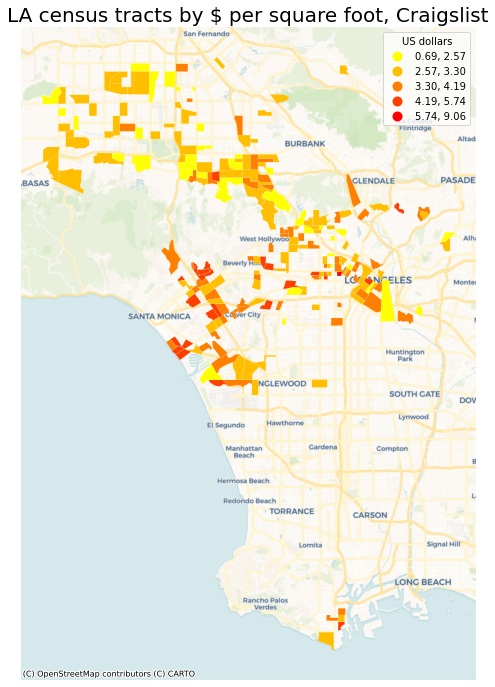

In [16]:
df_mercator = df.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
df_mercator.plot(column='$persqft', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("LA census tracts by $ per square foot, Craigslist",fontsize=20)
ax.get_legend().set_title("US dollars")
ctx.add_basemap(ax, crs=df_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

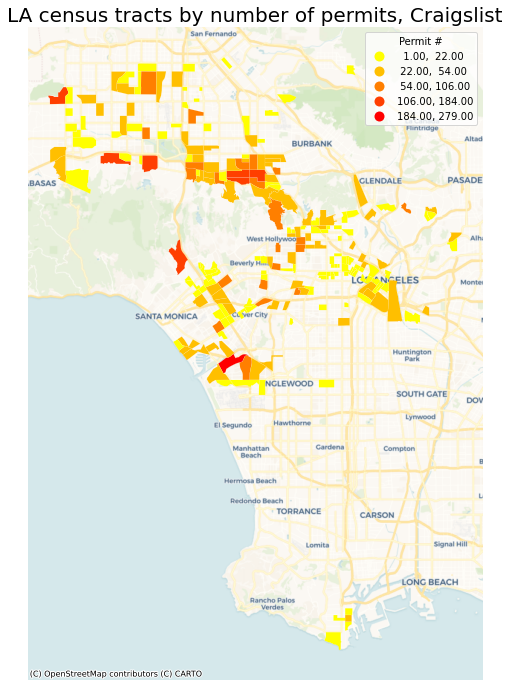

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))
df_mercator.plot(column='permit_count', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("LA census tracts by number of permits, Craigslist",fontsize=20)
ax.get_legend().set_title("Permit #")
ctx.add_basemap(ax, crs=df_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

Judging solely by the eye test, it appeared that there was some evidence for our hypothesis. Neighborhoods such as Westwood, Venice, and central Los Angeles had high rents and few permits; on the other hand, neighborhoods in the San Fernando Valley demonstrated the opposite pattern.

But we didn't want to conclude our analysis with an eye test. To start our modeling process, we ran a simple linear regression on our two variables of interest: building permit counts and the average rental price for each of our given census tracts.

In [18]:
a=df['permit_count']
e=df['avg price']
c=np.array(df['permit_count'])
d=np.array(df['avg price'])
m, b = np.polyfit(c, d, 1)

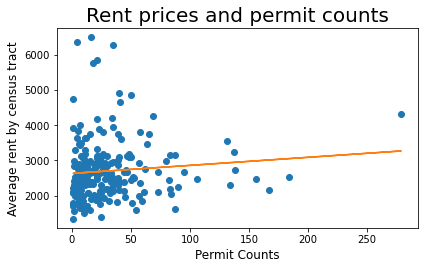

In [19]:
plt.plot(a,e,'o')
plt.plot(c, m*c + b)
plt.title(label="Rent prices and permit counts",
          fontsize=20,
          color="black",)
plt.xlabel('Permit Counts', fontsize=12)
plt.ylabel('Average rent by census tract', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [20]:
np.corrcoef(df['permit_count'], df['avg price'])

array([[1.        , 0.09466487],
       [0.09466487, 1.        ]])

We calculated a Pearson's correlation coefficient of 0.09, which indicated essentially no relationship between these two variables. We say this with some hestiation. For one, there are limitations to a linear model — a spatial autocorrelation or cluster analysis, for example, might tease out some stronger spatial relationships than may be evident on a simple plot. Additionally, we have the problem of relatively few observations and one strong outlier, which flattens the regression line significantly. (Without it, we can observe a slight negative relationship between permit counts and average rents.) Finally, the permit data was significantly right skewed, as the histogram below demonstrates. Because our permit data resists a normal distribution, it reduces its usefulness as a predictive variable.

<AxesSubplot:>

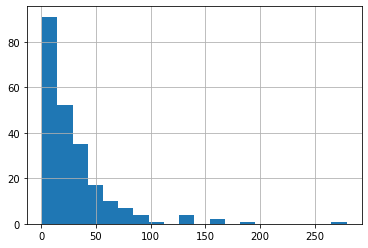

In [21]:
df['permit_count'].hist(bins=20)

With these limitations in mind, we set out to incorporate building permits into a broader machine learning model. We used the RandomForestRegressor to deal with our continuous variable, and included a slew of Census variables to pair with our building permits with the aim of increasing the predictive accuracy. We also created a new variable — high_ed — that combined percent of the census tract with a bachelor's degree, master's degree, and doctoral degree as a proxy for educational attainment.

In [25]:
df['high_ed']=df['PctBachelor']+df['PctMasters']+df['PctDoctorate']

In [26]:
xvars3 = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar3 = 'med price'
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    df[xvars3], df[yvar3], test_size = 0.25, random_state = 1)

In [28]:
rf3 = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf3.fit(X_train3, y_train3)
y_pred3 = rf3.predict(X_test3)

np.abs(y_pred3-y_test3).sum()

30933.010000000002

In [29]:
a5=y_test3
e5=y_pred3
c5=np.array(y_test3)
d5=np.array(y_pred3)
m5, b5 = np.polyfit(c5, d5, 1)

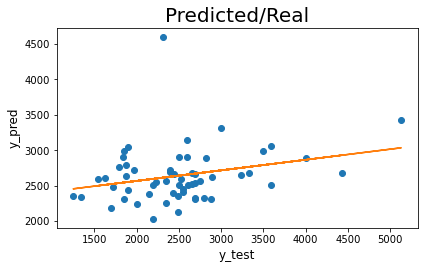

In [30]:
plt.plot(a5,e5,'o')
plt.plot(c5, m5*c5 + b5)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [31]:
np.corrcoef(y_test3,y_pred3)

array([[1.        , 0.27465783],
       [0.27465783, 1.        ]])

As the plot and the array above show, our machine learning model improved on the simple linear model's accuracy by a significant amount, producing a Pearson's correlation coefficient of 0.27. In plain English, this essentially conveyed to us that our chosen census variables and building permit information were somewhat successful in predicting the median Craigslist rental price in a given census tract.

That being said, there are some clear limitations to our initial dataframe. For one, we set the cutoff at five listings per census tract, which may or may not be a significant enough number of listings to justify a median rental price. To eliminate this concern, we filtered the dataframe to Census tracts with a minimum of 30 listings and re-ran our RandomForest model.

In [32]:
df_large_sample = df[(df['listing count'] >= 30)]

np.corrcoef(df_large_sample['$persqft'], df_large_sample['permit_count'])

array([[ 1.        , -0.12277551],
       [-0.12277551,  1.        ]])

(Interestingly, in this more statistically significant dataframe, a negative relationship was observed between price per square foot and permit count. In other words, the more permits in a given Census tract, the less the expected rent, which weakly supports our hypothesis.)

In [33]:
xvars4 = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar4 = 'med price'
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    df_large_sample[xvars4], df_large_sample[yvar4], test_size = 0.4, random_state = 1)

In [34]:
rf4 = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf4.fit(X_train4, y_train4)
y_pred4 = rf4.predict(X_test4)

In [35]:
a6=y_test4
e6=y_pred4
c6=np.array(y_test4)
d6=np.array(y_pred4)
m6, b6 = np.polyfit(c6, d6, 1)

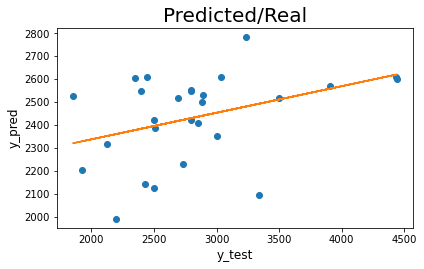

In [36]:
plt.plot(a6,e6,'o')
plt.plot(c6, m6*c6 + b6)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [37]:
np.corrcoef(y_test4,y_pred4)

array([[1.        , 0.38958372],
       [0.38958372, 1.        ]])

Here, we have some good news and bad news. On the good news side, we see our highest Pearson's correlation coefficient yet — the model with the larger samples delivers a 0.38 corrcoef. On the other hand, the plot shows that we have filtered our dataframe so many times that our overall number of observations is insufficent to draw any serious conclusions. 

To solve this issue, we reframed our predictive angle. Instead of attempting to predict the median rent price for a given census tract, we instead merged the listings dataframe with our census variables and the building permits with the goal of predicting the rent price for every single Craigslist listing.

In this new model, we used the census variables and the building permit counts for the listing's census tract to attempt to predict the price for that specific unit. This solved our observation size issue: instead of training our model on a couple dozen observations, we trained it on thousands.

In [38]:
df_model=pd.read_csv('Data/JOINED_CENSUS_LISTINGS_MAY_27.csv')

In [47]:
colstokeep=['posted','post title','neighborhood','URL','price','latlon','y','x']
df_model=df_model[colstokeep]
gdf = gpd.GeoDataFrame(
    df_model, geometry=gpd.points_from_xy(df_model.x, df_model.y))

In [48]:
df2=gpd.read_file('Data/Grand_Gdf.geojson')

In [49]:
model=gpd.sjoin(gdf.set_crs(epsg=4326),df2)

In [50]:
model=model.dropna()
model_test = model.drop_duplicates(subset = ["post title"])
model_test['high_ed']=model_test['PctBachelor']+model_test['PctMasters']+model_test['PctDoctorate']

/Users/alliepadgett/opt/anaconda3/envs/uds/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [51]:
model_test['price'] = model_test['price'].str.replace(',','')
model_test['price']= model_test['price'].apply(pd.to_numeric, errors='coerce')

After joining and some light cleaning, it was time to run the new and improved model.

In [53]:
xvars_ml = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar_ml = 'price'
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    model_test[xvars_ml], model_test[yvar_ml], test_size = 0.3, random_state = 1)

In [54]:
rf_ml = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf_ml.fit(X_train_ml, y_train_ml)
y_pred_ml = rf_ml.predict(X_test_ml)

In [55]:
a_ml=y_test_ml
e_ml=y_pred_ml
c_ml=np.array(y_test_ml)
d_ml=np.array(y_pred_ml)
m_ml, b_ml = np.polyfit(c_ml, d_ml, 1)

In [56]:
a_ml=y_test_ml
e_ml=y_pred_ml
c_ml=np.array(y_test_ml)
d_ml=np.array(y_pred_ml)
m_ml, b_ml = np.polyfit(c_ml, d_ml, 1)

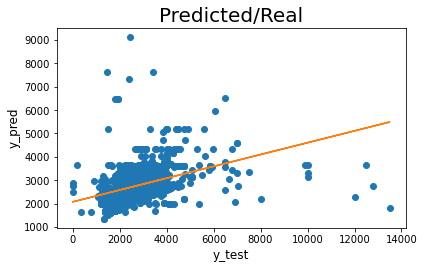

In [57]:
plt.plot(a_ml,e_ml,'o')
plt.plot(c_ml, m_ml*c_ml + b_ml)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [58]:
np.corrcoef(y_pred_ml,y_test_ml)

array([[1.        , 0.40420003],
       [0.40420003, 1.        ]])

Aha! This newfangled method for predicting the price of a given rental unit in our Craigslist dataframe produces our highest Pearson's correlation coefficient yet — and on a robust sample to boot. An additional benefit to this method is that we eliminate the concern of using census tracts with very few Craigslist listings.

After producing a satisfying model that appeared to have moderate strength in predicting the price of a Craigslist listing given socioeconomic characteristics and building permit issuances of a census tract, we were naturally curious which features influenced the predictive power most strongly. The results were surprising.

Text(181.99293407059605, 0.5, 'Percent contribution')

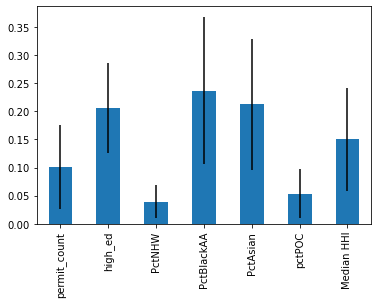

In [59]:
importances = rf_ml.feature_importances_
forest_importances_ml = pd.Series(importances, index=X_train_ml.columns)
std_ml = np.std([tree.feature_importances_ for tree in rf_ml.estimators_], axis=0)
fig_ml, ax_ml = plt.subplots()
forest_importances_ml.plot.bar(yerr=std_ml, ax=ax_ml)
ax.set_title("Feature importances of predictor variables")
ax.set_ylabel("Percent contribution")

The racial characteristics of the listing's census tract were by far the most influential in influencing the predictive power of the model. While the error bars are large, it is undeniable that building permits — our original variable of concern — pales in comparison to these other variables.

<a id='conclusion'></a>
## 5. Conclusion

What can we take away from all of this? Ultimately, we did not find much evidence for our hypothesis. While the eye test revealed some potentially interesting patterns, subsequent linear regressions found a weak relationship at best between the number of building permits issued and the rental prices in a given census tract. When building permits were incorporated into a larger soup of predictive variables for our random forests machine learning model, it did not particularly distinguish itself relative to variables such as the percentage of Black residents or the average household income in the tract.

With all of that said, the fact that no statistical relationship was found may present some interesting avenues for analysis on its own. It is useful to entertain the counterfactual: in a city such as Seattle or Portland, where the city responded to its housing crisis with a densification strategy, would this relationship be different? Instead of seeing a weak negative relationship between building permits and rental prices, would it instead be a moderate or even strong negative relationship? 

Said another way, it is possible that the lack of a relationship between these two variables of concern in the city of Los Angeles does not tell us much about the predictive nature of building permits, but instead something about Los Angeles itself. There simply have not been that many permits issued in the city over the last 10 years, especially relative to the demand for such housing, and without these permits, it is near-impossible to tell if they'd make a difference. 